<a href="https://colab.research.google.com/github/jgarvey928/Colab_Notebooks/blob/main/Job_Scapper_Ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install selenium nltk

# Import necessary libraries
from IPython import get_ipython
from IPython.display import display

# Standard Library Imports
import random
import re
import time

# Third-Party Library Imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
import pandas as pd

# Ensure necessary NLTK data is downloaded
# These downloads are important for text processing tasks later in the notebook
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# The following downloads might not be standard or needed, you might want to
# verify if they are truly required for your analysis.
nltk.download('punkt_tab') # Usually not needed for standard text processing
nltk.download('averaged_perceptron_tagger') # Useful for pos_tagging
nltk.download('averaged_perceptron_tagger_eng') # Likely the same as the above or a specific English version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
typeguard 4.4.3 requires typing_extensions>=4.14.0, but you have typing-extensions 4.13.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and pla

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# --- User Input ---
# This section prompts the user to provide the necessary information

# Prompt the user for the LinkedIn job search URL.
website_link = input("Enter the website link: ")
if website_link.strip() == "":

    # "https://www.linkedin.com/jobs/search?keywords=Software%20Developer&location=United%20States&f_E=2%2C3&f_TPR=r2592000&position=1&pageNum=0"
    # "https://www.linkedin.com/jobs/search/?currentJobId=4233045827&distance=25.0&f_E=2%2C3&f_TPR=r2592000&f_WT=1%2C3&keywords=software%20developer&origin=JOB_SEARCH_PAGE_JOB_FILTER"
    # "https://www.linkedin.com/jobs/search?keywords=Software%20Development&location=United%20States&f_TPR=&f_E=2%2C3&position=1&pageNum=0"
    # "https://www.linkedin.com/jobs/search?keywords=Software%20Engineer&location=United%20States&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0"
    # "https://www.linkedin.com/jobs/search?keywords=Software%20Development&location=Greater%20Phoenix%20Area&f_JT=F&f_E=2&f_TPR=&f_WT=1%2C3&position=1&pageNum=0"
    # "https://www.linkedin.com/jobs/search?keywords=Software%20Development&location=United%20States&geoId=103644278&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0"

    website_link = "https://www.linkedin.com/jobs/search?keywords=Software%20Development&location=Greater%20Phoenix%20Area&f_JT=F&f_E=2&f_TPR=&f_WT=1%2C3&position=1&pageNum=0"
    print(f"No website provided. Using default: {website_link}")

# Prompt the user for a base name to use for the output CSV and PDF files.
name_files = input("Enter the name for the output files: ")
if name_files.strip() == "":
    name_files = "linkedin_datascrpr_test"
    print(f"No file name provided. Using default: {name_files}")

# Prompt the user for the maximum number of job listings to scrape.
while True:
    max_listings_input = input("Enter the maximum number of listings to scrape (as a number): ")
    if max_listings_input.strip() == "":
        max_listings = 100
        print(f"No input provided. Using default max listings: {max_listings}")
        break
    try:
        max_listings = int(max_listings_input)
        if max_listings > 0:
            break # Valid input, exit the loop
        else:
            print("Please enter a positive number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Define a default wait time for page loading during scraping.This can be adjusted.
wait_seconds = 2
# wait_seconds = int(input("Enter the wait time in seconds (as a number): "))

Enter the website link: 
No website provided. Using default: https://www.linkedin.com/jobs/search?keywords=Software%20Development&location=Greater%20Phoenix%20Area&f_JT=F&f_E=2&f_TPR=&f_WT=1%2C3&position=1&pageNum=0
Enter the name for the output files: 
No file name provided. Using default: linkedin_datascrpr_test
Enter the maximum number of listings to scrape (as a number): 
No input provided. Using default max listings: 100


In [ ]:
def scrape_data(name_file, website_link, post_limit, wait_time=1):
    """Scrapes job data from LinkedIn and saves it to a CSV file.

    Args:
        name_file (str): The base name for the output CSV file.
        website_link (str): The URL of the LinkedIn job search page.
        post_limit (int): The maximum number of job postings to scrape.
        wait_time (int, optional): The time in seconds to wait for elements to load. Defaults to 1.
    Returns:
        pd.DataFrame: A DataFrame containing the scraped job data.
    """
    # Initialize WebDriver with headless option for Colab environment
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    # # Proxy ----------------------------------------------------------
    # proxy_ip = "159.69.57.20"
    # proxy_port = "8880"  # <<< REPLACE WITH THE ACTUAL PORT FROM PROXYSCRAPE
    # proxy_server = f"{proxy_ip}:{proxy_port}"
    # print(f"Attempting to use proxy: {proxy_server}") # Optional: Print the proxy being used
    # chrome_options.add_argument(f'--proxy-server={proxy_server}')
    # # ----------------------------------------------------------

    try:
        # Initialize the Chrome driver with the specified options
        driver = webdriver.Chrome(options=chrome_options)
        # Navigate to the LinkedIn job search URL
        driver.get(website_link)
        # Send Escape Key Press to Clear Any Pop Ups (e.g., cookie banners)
        webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()

        for _ in range(10):
          driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
          time.sleep(1)

        try:
            # Try to click the "See more jobs" button a few times
            for _ in range(10): # Attempt up to X times
                try:
                    see_more_button = WebDriverWait(driver, 5).until(
                        EC.element_to_be_clickable((By.CLASS_NAME, 'infinite-scroller__show-more-button'))
                    )
                    see_more_button.click()
                    print("Clicked 'See more jobs' button.")
                    time.sleep(0.5) # Wait for content to load
                    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                except TimeoutException:
                    print("No more 'See more jobs' button or it's not clickable.")
                    break # Exit the loop if the button is not found
        except Exception as e:
            print(f"An error occurred while trying to click 'See more jobs': {e}")


        job_data = []  # Initialize an empty list to store job data
        count = 0

        # # Find all job listing elements on the current page
        job_listings = driver.find_elements(By.XPATH, '//section[@class="two-pane-serp-page__results-list"]/ul/li')


        # Loop through job listings up to the specified limit
        while count < post_limit+1:
            if not job_listings:
                # Break the loop if no listings are found
                print(f"Error finding website")
                break

            try:
                # Get the current job listing element
                listing = job_listings[count]
                # Extract key information from the job listing summary
                job_title = listing.find_element(By.CLASS_NAME, 'base-search-card__title').text
                company = listing.find_element(By.CLASS_NAME, 'base-search-card__subtitle').text
                address = listing.find_element(By.CLASS_NAME, 'job-search-card__location').text
                date = listing.find_element(By.XPATH, '//*[starts-with(@class, "job-search-card__listdate")]').text
                job_link = listing.find_element(By.CLASS_NAME, 'base-card__full-link').get_attribute('href')

                # Open job details in a new tab to get the full description
                driver.execute_script("window.open('');")
                # Switch to the new tab
                driver.switch_to.window(driver.window_handles[-1])
                # Navigate to the job link in the new tab
                driver.get(job_link)
                # Send Escape Key Press in the new tab to clear potential pop-ups
                webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()

                # Wait for the job description element to load
                time.sleep(wait_time) # Using the passed wait_time

                # Locate the job description section
                # Locate the element containing the actual description text
                description_element = driver.find_element(By.XPATH, '//*[@class="description__text description__text--rich"]')

                # Extract and prettify the HTML of the description
                description_html = description_element.get_attribute('innerHTML')
                pretty_html = BeautifulSoup(description_html, 'html.parser').prettify()

                # Append the extracted data to the job_data list
                job_data.append([job_title, company, date, address, job_link, pretty_html])

                # Close the current tab and switch back to the main window
                driver.close()
                driver.switch_to.window(driver.window_handles[0])

            except StaleElementReferenceException:
                # Handle cases where the element is no longer available in the DOM
                print(f"StaleElementReferenceException occurred for listing {count}. Retrying...")
                continue  # Skip to the next iteration and try again
            except TimeoutException:
                # Handle cases where an element is not found within the wait time
                print(f"TimeoutException occurred for listing {count}. Element not found. Skipping this job.")
                continue  # Skip to the next iteration and try again
            except Exception as e:
                # Catch any other unexpected exceptions during scraping a single listing
                print(f"An unexpected error occurred for listing {count}: {e}. Skipping this job.")
                continue
            finally:
                # Increment the count regardless of whether an error occurred or not
                count += 1

    except Exception as e:
        # Catch any exceptions during the initial driver setup or page load
        print(f"An error occurred during the initial scraping setup or page load: {e}")
        # Return an empty DataFrame in case of initial errors
        df = pd.DataFrame()

    finally:
        # Ensure the driver is quit even if errors occur
        if 'driver' in locals() and driver:
            driver.quit()

    # Create a pandas DataFrame from the scraped data
    df = pd.DataFrame(job_data, columns=["Job Title", "Company", "Date", "Address", "Link", "Description"])

    # Remove duplicate entries based on Job Title and Company
    df.drop_duplicates(subset=["Job Title", "Company"], keep="first", inplace=True)

    # Define the output CSV file path
    output_csv_path = f"{name_file}.csv" # Removed hardcoded 'Files/'

    # Save the DataFrame to a CSV file
    try:
        df.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"Data saved to {output_csv_path}")
    except Exception as e:
        # Handle potential errors during the file saving process
        print(f"Error saving data to CSV: {e}")

    # Return the DataFrame
    return df

# Execute the scraping function with user inputs
# The wait_seconds variable is defined earlier from user input or defaults
job_listings_df = scrape_data(name_files, website_link, max_listings, wait_time=wait_seconds)

No more 'See more jobs' button or it's not clickable.
An unexpected error occurred for listing 3: list index out of range. Skipping this job.
An unexpected error occurred for listing 4: list index out of range. Skipping this job.
An unexpected error occurred for listing 5: list index out of range. Skipping this job.
An unexpected error occurred for listing 6: list index out of range. Skipping this job.
An unexpected error occurred for listing 7: list index out of range. Skipping this job.
An unexpected error occurred for listing 8: list index out of range. Skipping this job.
An unexpected error occurred for listing 9: list index out of range. Skipping this job.
An unexpected error occurred for listing 10: list index out of range. Skipping this job.
An unexpected error occurred for listing 11: list index out of range. Skipping this job.
An unexpected error occurred for listing 12: list index out of range. Skipping this job.
An unexpected error occurred for listing 13: list index out of 

In [ ]:
# %%
# Initialize the list of keywords to identify requirement sections
keywords = [
    "requirements", "requirement", "qualifications", "qualification", "required education and experience",
    "skills/qualifications", "skills/qualification", "must have", "required skills", "desired skills",
    "preferred qualifications", "preferred qualification", "basic qualifications", "basic qualification",
    "essential skills", "essential skill", "job requirements", "job requirement", "job qualifications",
    "job qualification", "required experience", "preferred experience", "required education", "desired qualifications",
    "desired qualification", "experience", "education", "skills", "skill", "must-have", "must haves", "must-have skills",
    "must-have skill", "required", "preferred", "essential", "basic", "necessary", "mandatory", "needed", "desired",
    "Who Should Apply", "What We're Looking For", "What You'll Do", "What You'll Need",
    "What You'll Bring", "What You'll Be Doing", "What You'll Be Responsible For", "What do you need to have",
    "What Do You Need To Bring", "What You'll Need To Bring", "What You'll Need To Have", "What You'll Need To Do",
    "you'll use", "Nice To Have",
]

In [ ]:
# Compile a regular expression pattern to match any of the keywords
keywords_pattern = re.compile('|'.join([re.escape(keyword) for keyword in keywords]), re.IGNORECASE)

# Function to check if a string contains any of the keywords
def contains_keywords(text):
    return bool(keywords_pattern.search(text))

def not_single_word(text):
    return ' ' in text

def clean_html(description):
    soup = BeautifulSoup(description, 'html.parser')
    text = soup.get_text(separator="\n")
    # Remove leading/trailing whitespaces and empty lines
    cleaned_text = "\n".join([line.strip() for line in text.splitlines() if line.strip()])
    return cleaned_text

def extract_csv(df):
    modified_rows = []
    all_requirements = []
    fieldnames = df.columns.tolist() + ['Cleaned'] + ['Requirements']

    for index, row in df.iterrows():
        collected_text = []

        collected_text.append(row['Job Title']+" "+row['Company']+" "+row['Date']+" "+row['Address'])
        description = row['Description']
        soup = BeautifulSoup(description, 'html.parser')

        strong_elements = soup.find_all('strong')
        i = 0
        for strong in strong_elements:

            if contains_keywords(strong.get_text(strip=True)):
                i += 1
                collected_text.append("\n" + str(i) + "\n")
                collected_text.append(strong.get_text(strip=True))

                for sibling in strong.next_siblings:
                    if sibling.name == 'strong':
                        break
                    # if sibling.name in ['p', 'li', 'br', 'span']:
                    #     text1 = sibling.get_text().strip()
                    #     if text1:
                    #         collected_text.append("     #######     "+text1)
                    elif isinstance(sibling, str):
                        text2 = sibling.strip()
                        if text2:
                            collected_text.append(text2)

                for sibling in strong.find_all_next():
                    if sibling.name == 'strong':
                        break
                    if sibling.name in ['p', 'li', 'br', 'span']:
                        text1 = sibling.get_text(strip=True)
                        if text1:
                            collected_text.append(text1)

        li_elements = soup.find_all('li')
        for li in li_elements:
            collected_text.append(li.get_text(strip=True))

        collected_text.append("\n__________________________________________________\n")

        seen = set()
        unique_collected_text = []
        for section in collected_text:
            if section not in seen:
                unique_collected_text.append(section)
                seen.add(section)

        row_dict = row.to_dict()
        row_dict['Cleaned'] = clean_html(row_dict['Description'])
        row_dict['Requirements'] = "\n".join(unique_collected_text)
        all_requirements.extend(unique_collected_text)
        modified_rows.append(row_dict)

    modified_df = pd.DataFrame(modified_rows)
    return modified_df, all_requirements

def download_data(name_file, df):
    modified_df, all_requirements = extract_csv(df)
    modified_df.to_csv(name_file + '.csv', index=False, encoding='utf-8')

    requirements = all_requirements
    requirements = [req for req in requirements if req.strip()]

    with open(name_file + '_reqs.txt', 'w', encoding='utf-8') as file:
        for req in requirements:
            req = req.replace('\n', '')
            print(req)
            file.write(req+"\n")

download_data(name_files, job_listings_df)

1
Qualifications:
Pursuing a bachelor's or master’s degree in computer science, engineering, or equivalent.
Previous internship experience ideally.
Working towards a proficiency of one or more programming languages such as Typescript, Node.js, or Python.
You find large challenges exciting and enjoy discovering problems as much as solving them.
You are able to problem-solve and adapt to changing priorities in a fast-paced, dynamic environment.
This internship will take place from September 15 - December 5 and you will need to be able to work out of our SF office during this time.
Skills You’ll Need To Bring:
2
Thoughtful problem-solving:For you, problem-solving starts with a clear and accurate understanding of the context. You can decompose tricky problems and work towards a clean solution, by yourself or with teammates. You're comfortable asking for help when you get stuck.
3
Nice to Haves:
You have expertise with specific technologies that are part of our stack, including Typescript, 

In [ ]:
# %%
# Initialize the set of custom stop words for text analysis
custom_stop_words = set([
        "year", "years", "work", "working", "use", "using", "new", "understand",
        "knowledge", "skills", "ability", "must", "have", "with", "the", "and",
        "or", "to", "a", "in", "of", "for", "on", "as", "is", "are", "understanding", "experience",
        "software", "development", "developer", "technologies", "technology",
        "strong", "design", "business", "computer","degree", "related", "environment", "solution",
        "project", "engineering", "technical", "system", "application", "applications",
        "solutions", "preferred", "data", "problem", "excellent", "plus", "practice",
        "skill", "team", "teams", "support", "science", "life", "basic", "best",
        "within", "security", "required", "approach","role", "service", "services", "field",
        "familiarity", "equivalent", "learn", "industry", "build", "building",
        "academic", "cumulative", "gpa", "company", "companies", "government",
        "agency", "agencies", "perform", "performing", "performs","text","week",
        "tech", "clients", "client", "skillstorm", "built", "paid", "enterprise",
        "oriented", "user", "requirement", "requirements", "professional",
        "management", "information", "cycle", "proficiency", "methodology",
        "verbal", "proficient", "one", "platform", "platforms","opportunities",
        "across", "interview", "interviews", "professionals","impact","modern","youll",
        "office", "developing", "level", "training", "partner", "partners",
        "position", "equal", "greater", "open", "language", "languages","call","right","key",
        "procedure", "procedures", "delivery", "general", "issue", "issues", "and/or",
        "2", "hands-on", "etc.", "on-site", "framework", "frameworks",
        "coding", "time", "ii", "configuration", "configurations", "product", "products", "scripting",
        "provide", "providing", "production", "implement", "implementing", "code",
        "perform", "career", "contribute", "contributing", "selected","high","drive",
        "demonstrate", "demonstrated", "develop", "developing", "desire",
        "previous", "pattern", "effectively", "salary", "compensation","phoenix","message","kforce",
        "benefit", "benefits", "combination", "similar", "end", "expertise","scottsdale","receive","rate",
        "like", "good", "core", "spring", "slack", "e.g.", "highly", "performance",
        "candidate", "job", "feature", "features", "remote", "program", "programs", "quality",
        "insurance", "get", "engineer", "engineers", "master", "opportunity",
        "employee", "employees", "please", "take", "u", "review", "flexible",
        "manager", "managers", "maintain", "maintaining", "synergisticit", "electrical",
        "minimum", "help", "helping", "infrastructure","deployment", "deployments", "boot",
        "qualification", "qualifications", "leave", "participate", "participating",
        "supporting", "based", "startup", "startups", "comprehensive",
        "world", "continuously", "make", "making", "share", "sharing", "growth", "ownership",
        "implementation", "implementations", "mobile", "looking", "existing", "web",
        "jobseekers", "customer", "customers", "someone", "love", "important", "helped", "care",
        "fully", "know", "market", "markets", "assist", "assisting",
        "company-paid", "history", "change", "changes", "part", "standard", "standards",
        "assigned", "specification", "specifications", "document", "documents",
        "health", "apply", "applying", "schedule", "schedules","effective","account",
        "stakeholder", "stakeholders", "pay", "functional", "relevant",
        "education", "create", "creating", "clearance", "without", "also", "creating", "per",
        "task", "tasks", "collaborative", "hour", "hours", "united","large","concept",
        "duty", "duties", "relocation", "sponsorship", "state", "states",
        "control", "controlling", "manage", "managing", "dental", "closely", "medical", "email",
        "organization", "organizations", "scope", "day", "ensuring", "visa",
        "excellence", "specific", "solve", "lead", "leading", "keep",
        "global", "internal", "external", "member", "members", "able",
        "request", "requests", "various", "operational", "attention","space","relate","levelfull",
        "disability", "responsibility", "responsibilities", "operation", "operations",
        "department", "departments", "operating", "employer", "location", "locations", "source", "etl",
        "offer", "offering", "levelentry", "employment", "typefull-timejob", "principle",
        "principles", "include", "including", "write", "writing","boston","would","ago","az",
        "range", "base", "utilize", "utilizing", "deliver", "delivering", "gain",
        "contributor", "contributors", "drive", "driving", "foster", "fostering",
        "navigate", "navigating", "optimize", "optimizing", "gaining", "leverage", "leveraging",
        "troubleshoot", "troubleshooting", "validate", "validating", "verify",
        "monitor", "monitoring", "guide", "guiding", "mentor", "mentoring", "collaborate",
        "collaborating", "communicate", "communicating","verifying", "usd",
        "improve", "eg", "require", "least","prefer", "game",
        "seniority", "dynamic","e","g","etc","assess", "assessing", "evaluate", "evaluating",
        "practices", "process", "processes", "including", "tool", "tools", "written",
        "vision", "stack", "person", "complex", "well", "result", "results", "need", "needed", "analytical"
        "status", "eligible", "ensure", "ensuring", "may", "area", "areas", "vehicle",
        "meet", "meeting", "u.s.", "plan", "plans", "appropriate", "success",
        "policy", "policies", "necessary", "conduct", "conducting", "workflow", "workflows",
        "keeping", "detail", "details", "identify", "identifying", "continuous", "power",
        "grow","equity","san","francisco","multiple","search","people","bonus","stay",
        "passion","parental","401k","ca","status","match","pto","york","comfortable",
        "holiday","find","follow","link", "palo","alto", "action","believe",
        "race","gender","color","identify", "origin", "national", "protect","veteran",
        "orientation","regard","sexual","identity","age","genetic","military",

    ])

# Add User Input Words to Remove

Successfully loaded data from linkedin_datascrpr_test.csv


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['hands', 'site', 'timejob', 'typefull'] not in stop_words.
  warnings.warn(


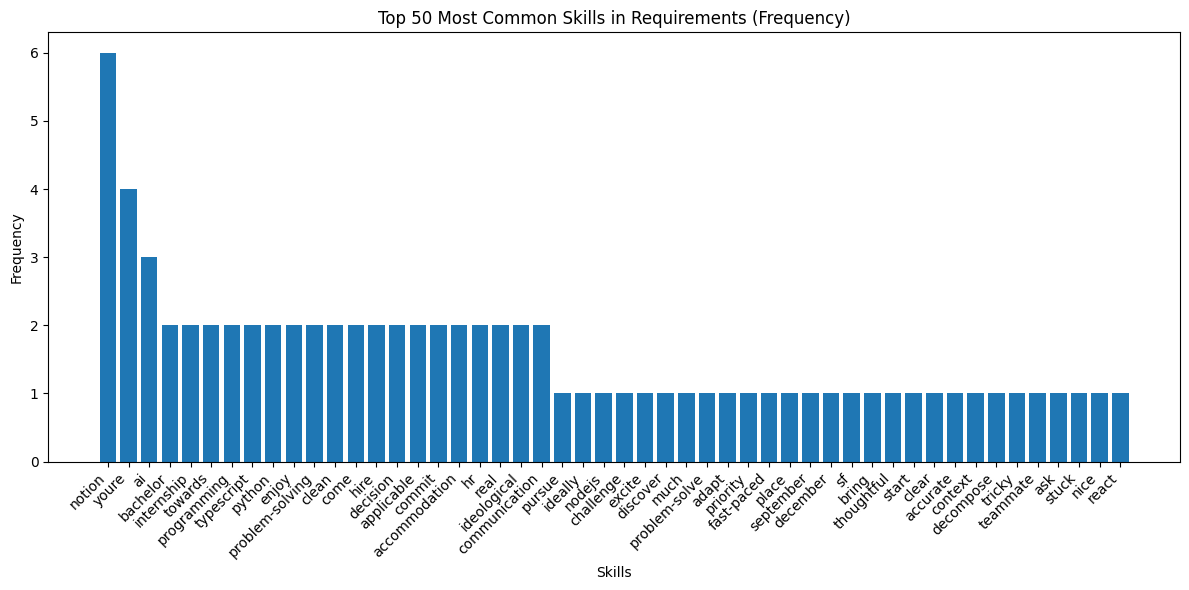

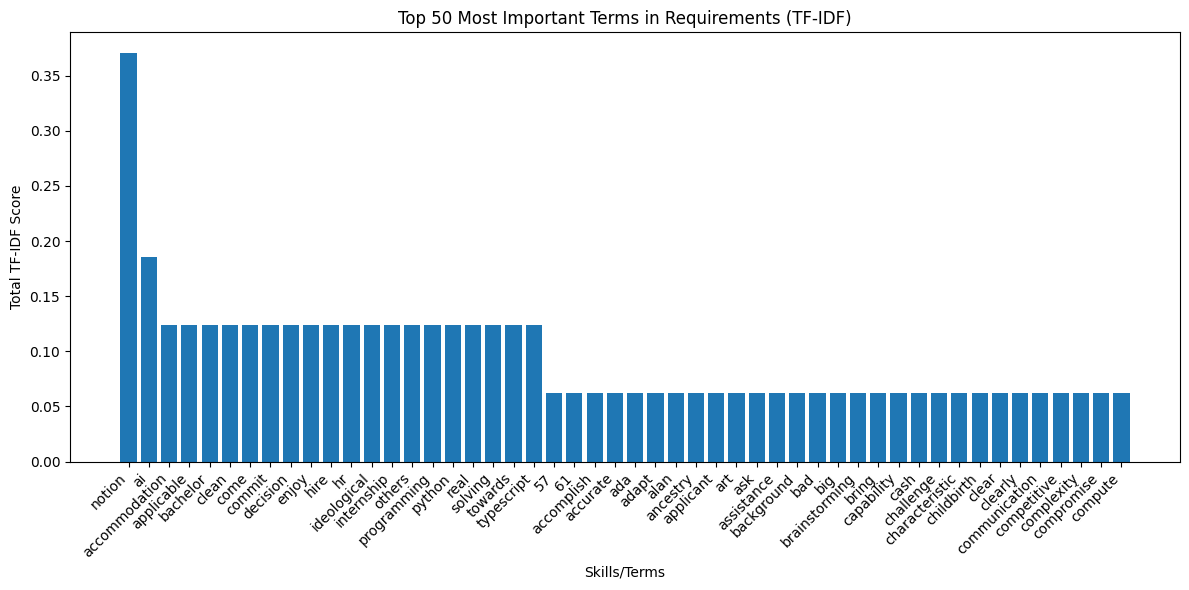

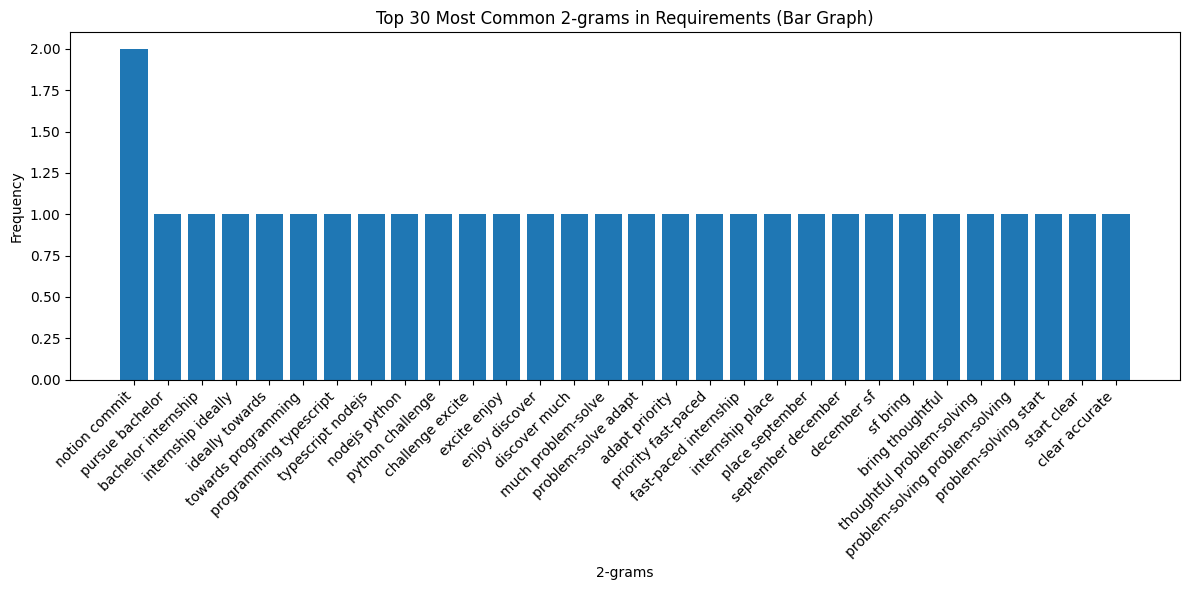

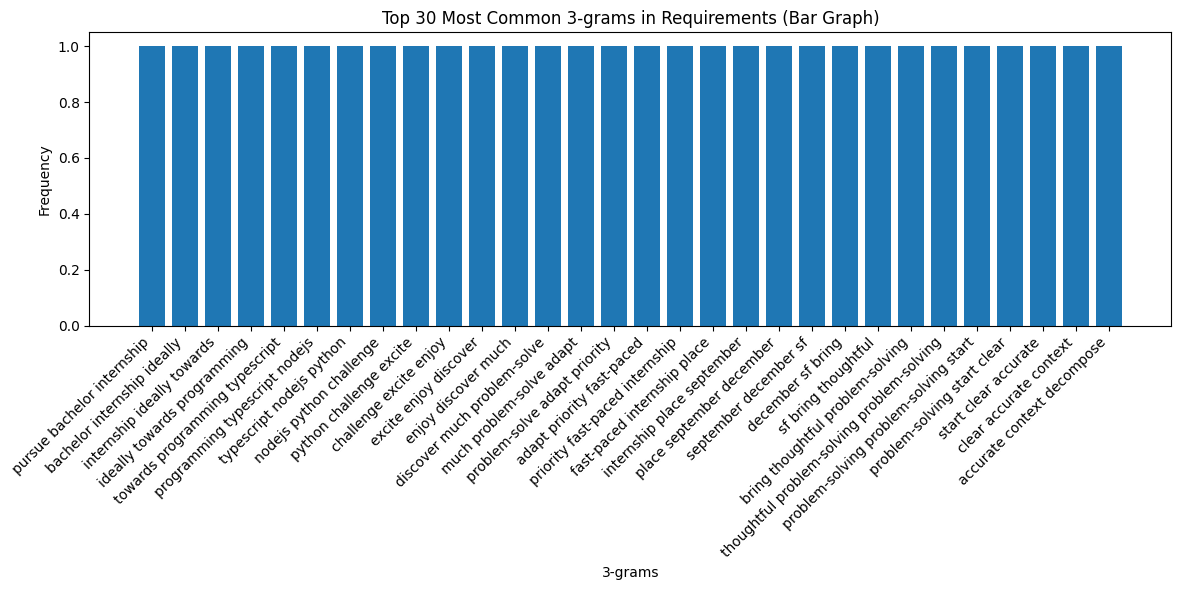

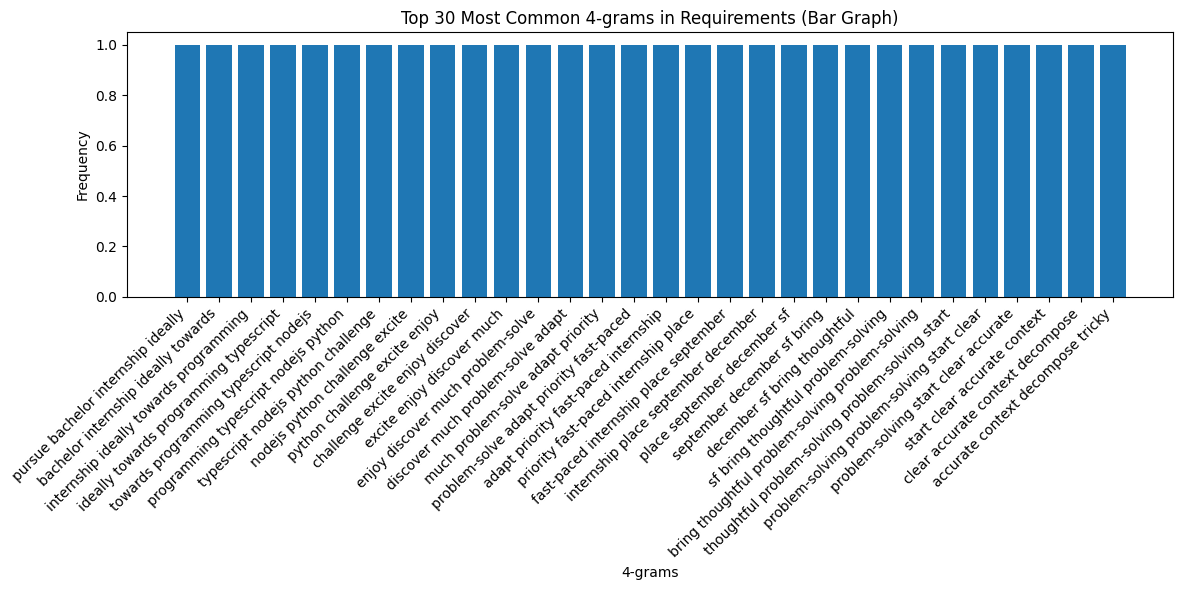

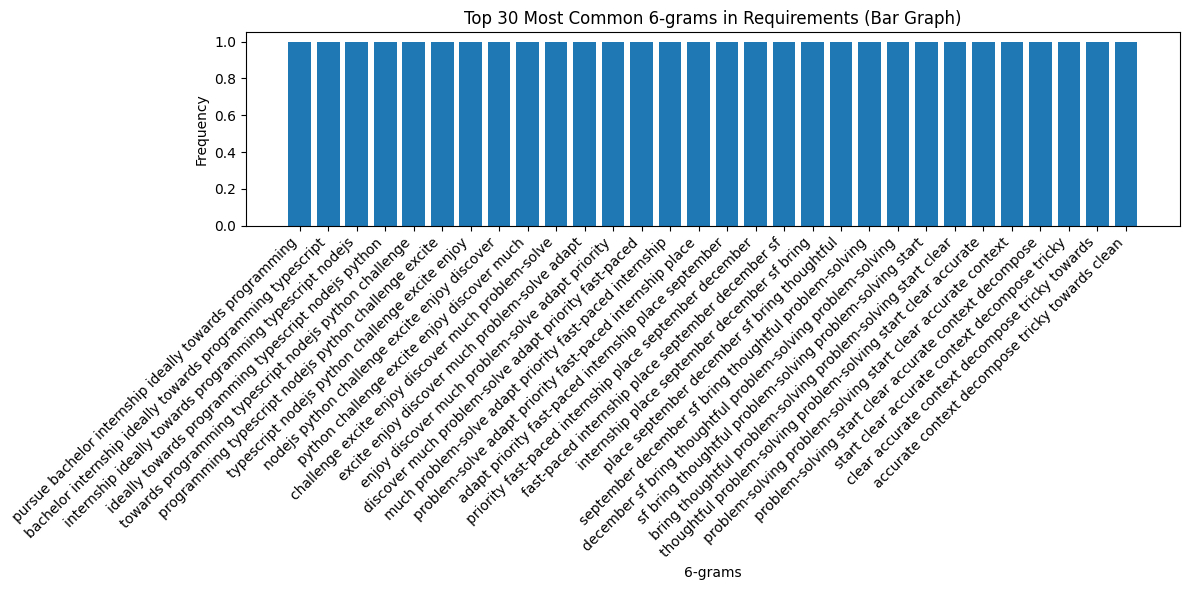

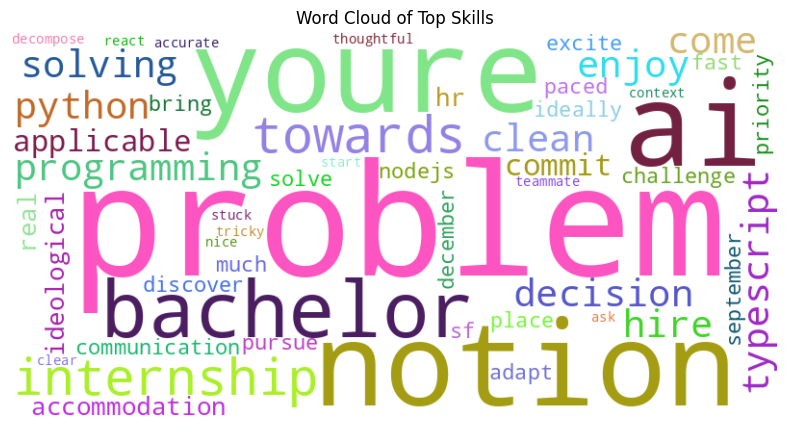

Analysis complete. Plots saved to linkedin_datascrpr_test_analysis.pdf


In [ ]:

# Function to read requirements from the file
# Modified to read from a DataFrame instead
def read_requirements(df):
    """
    Combines the 'Requirements' column from a DataFrame into a single string.

    Args:
        df (pd.DataFrame): The DataFrame containing job data with a 'Requirements' column.

    Returns:
        str: A single string containing all combined requirements.
    """
    data = df['Requirements'].str.cat()
    return '\n'.join(data.split("\n__________________________________________________\n"))

# Function to combine similar words
def combine_similar_words(tokens, word1, word2):
    """
    Replaces occurrences of word2 with word1 in a list of tokens.

    Args:
        tokens (list): A list of words (tokens).
        word1 (str): The word to replace with.
        word2 (str): The word to be replaced.

    Returns:
        list: A new list of tokens with replacements.
    """
    combined_tokens = []
    for token in tokens:
        if token == word1 or token == word2:
            combined_tokens.append(word1)
        else:
            combined_tokens.append(token)
    return combined_tokens

# Frequency Analysis
def frequency_analysis(tokens, num_top, pdf):
    """
    Performs frequency analysis on tokens, generates bar and pie charts,
    and updates the global top_skills list.

    Args:
        tokens (list): A list of tokens for analysis.
        num_top (int): The number of top frequent items to display.
        pdf (PdfPages): The PDF object to save plots to.
    """

    # Count the frequency of each token
    frequency = Counter(tokens)
    # Get the most common tokens
    most_common = frequency.most_common(num_top)
    words, counts = zip(*most_common)

    # Store the top most frequent tokens in the global list
    top_skills = list(words)

    # Generate and save Bar Graph
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xlabel('Skills')
    plt.ylabel('Frequency')
    plt.title(f'Top {num_top} Most Common Skills in Requirements (Frequency)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()
    return top_skills


# Custom color function for word clouds
def random_color_func(word=None, font_size=None, position=None, orientation=None, random_state=None, **kwargs):
    """Generates a random HSL color."""
    return "hsl({}, {}%, {}%)".format(random.randint(0, 360), random.randint(50, 100), random.randint(25, 75))

# Word Cloud
def generate_word_cloud(text, title, pdf):
    """
    Generates a word cloud from the given text and saves it to a PDF.

    Args:
        text (str): The text to generate the word cloud from.
        title (str): The title for the word cloud plot.
        pdf (PdfPages): The PDF object to save the plot to.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=random_color_func).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Hide axes
    plt.title(title)
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()

# N-gram Analysis
def ngram_analysis(tokens, n, num_top, pdf):
    """
    Performs N-gram analysis, generates a pie chart, and saves it to a PDF.

    Args:
        tokens (list): A list of tokens for N-gram analysis.
        n (int): The size of the N-grams.
        num_top (int): The number of top N-grams to display.
        pdf (PdfPages): The PDF object to save the plot to.
    """
    # Generate N-grams
    n_grams = ngrams(tokens, n)
    # Count the frequency of each N-gram
    ngram_frequency = Counter(n_grams)
    # Get the most common N-grams
    most_common = ngram_frequency.most_common(num_top)

    if not most_common:
        print(f"No {n}-grams found to analyze.")
        return

    ngrams_list, counts = zip(*most_common)
    # Create labels for the pie chart
    ngrams_labels = [' '.join(ngram) for ngram in ngrams_list]

    # # Generate and save Pie Chart for N-grams
    # plt.figure(figsize=(10, 5))
    # plt.pie(counts, labels=[f'{label} ({count})' for label, count in zip(ngrams_labels, counts)], autopct='%1.1f%%',
    #         startangle=140)
    # plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    # plt.title(f'Top {num_top} Most Common {n}-grams in Requirements')
    # pdf.savefig()  # Save the current figure to the PDF
    # plt.show()

    # --- Generate and save Bar Graph for N-grams ---
    plt.figure(figsize=(12, 6))
    plt.bar(ngrams_labels, counts)
    plt.xlabel(f'{n}-grams')
    plt.ylabel('Frequency')
    plt.title(f'Top {num_top} Most Common {n}-grams in Requirements (Bar Graph)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()

def get_wordnet_pos(tag):
    """
    Maps an NLTK part-of-speech tag to a WordNet part-of-speech tag.

    Args:
        tag (str): The NLTK part-of-speech tag.

    Returns:
        str or None: The corresponding WordNet tag ('a', 'v', 'n', 'r') or None.
    """
    if tag.startswith('J'):
        return 'a' # Adjective
    elif tag.startswith('V'):
        return 'v' # Verb
    elif tag.startswith('N'):
        return 'n' # Noun
    elif tag.startswith('R'):
        return 'r' # Adverb
    else:
        return None # Default to noun if not found

def get_tfidf_features(df):
    """
    Calculates TF-IDF features for the 'Requirements' column in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing job data with a 'Requirements' column.

    Returns:
        tuple: A tuple containing:
            - tfidf_matrix (sparse matrix): The TF-IDF matrix.
            - feature_names (list): The list of terms (features) from the vectorizer.
    """
    if df.empty or 'Requirements' not in df.columns:
        print("DataFrame is empty or does not have a 'Requirements' column for TF-IDF analysis.")
        return None, None

    # We need a list of strings, where each string is the processed requirements
    # for a single job listing. Let's re-process the requirements for TF-IDF.
    processed_descriptions = []
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    all_stop_words = stop_words.union(custom_stop_words)


    for description in df['Requirements']:
        if pd.notna(description): # Check if description is not NaN
            tokens = word_tokenize(description)
            lemmatized_and_filtered_tokens = []
            pos_tags = nltk.pos_tag(tokens)
            for word, tag in pos_tags:
                 wordnet_tag = get_wordnet_pos(tag)
                 if wordnet_tag is None:
                    lemma = lemmatizer.lemmatize(word.lower())
                 else:
                    lemma = lemmatizer.lemmatize(word.lower(), wordnet_tag)

                 # More robust filtering: ensure it has letters and not a stop word after lemmatization
                 if re.search(r'[a-zA-Z]', lemma) and lemma not in all_stop_words:
                    lemmatized_and_filtered_tokens.append(lemma)

            processed_descriptions.append(" ".join(lemmatized_and_filtered_tokens))
        else:
             processed_descriptions.append("") # Add empty string for missing descriptions

    if not processed_descriptions:
        print("No processed descriptions available for TF-IDF.")
        return None, None

    # Initialize TF-IDF Vectorizer
    # You can adjust max_features and other parameters as needed
    tfidf_vectorizer = TfidfVectorizer(max_features=200, stop_words=list(all_stop_words)) # Added stop_words here as well
    tfidf_matrix = tfidf_vectorizer.fit_transform(processed_descriptions)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return tfidf_matrix, feature_names

# Function to plot TF-IDF scores
def plot_tfidf_bar_graph(tfidf_matrix, feature_names, num_top, pdf):
    """
    Plots a bar graph of the top TF-IDF features.

    Args:
        tfidf_matrix (sparse matrix): The TF-IDF matrix.
        feature_names (list): The list of terms (features) from the vectorizer.
        num_top (int): The number of top TF-IDF features to display.
        pdf (PdfPages): The PDF object to save the plot to.
    """
    if tfidf_matrix is None or feature_names is None:
        print("No TF-IDF data available to plot.")
        return

    # Sum the TF-IDF scores across all documents for each feature
    sum_tfidf = tfidf_matrix.sum(axis=0)

    # Get the feature names and their summed TF-IDF scores
    tfidf_scores = [(feature_names[i], sum_tfidf[0, i]) for i in range(len(feature_names))]

    # Sort the features by their summed TF-IDF scores in descending order
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

    # Get the top N features and their scores
    top_tfidf_features = tfidf_scores[:num_top]
    words, scores = zip(*top_tfidf_features)

    # Generate and save Bar Graph for TF-IDF
    plt.figure(figsize=(12, 6))
    plt.bar(words, scores)
    plt.xlabel('Skills/Terms')
    plt.ylabel('Total TF-IDF Score')
    plt.title(f'Top {num_top} Most Important Terms in Requirements (TF-IDF)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()


# Analyze Data
def analyze_data(name_file, df):
    """
    Analyzes job requirements from a DataFrame and generates visualizations.

    Args:
        name_file (str): The base name for output files.
        df (pd.DataFrame): The DataFrame containing job data with a 'Requirements' column.
    """
    if df.empty:
        print("DataFrame is empty. No data to analyze.")
        return

    # Load requirements from the DataFrame
    # Combine all requirements into a single string
    all_requirements_combined = read_requirements(df)
    all_requirements_combined = all_requirements_combined.lower()
    all_requirements_combined = re.sub(r'[&`;:!@^{}/()=~<>\"]', ' ', all_requirements_combined)
    all_requirements_combined =  re.sub(r"[\'.,_\\]", '', all_requirements_combined)
    all_requirements_combined = all_requirements_combined.replace("machine learning","machinelearning")
    all_requirements_combined = all_requirements_combined.replace('c plus plus','c++')
    all_requirements_combined = all_requirements_combined.replace('artificial intelligence','ai')
    all_requirements_combined = all_requirements_combined.replace('data science','datascience')
    all_requirements_combined = all_requirements_combined.replace('back end','backend')
    all_requirements_combined = all_requirements_combined.replace('front end','frontend')
    all_requirements_combined = all_requirements_combined.replace('full stack','full-stack')
    all_requirements_combined = all_requirements_combined.replace('ci cd','ci-cd')
    all_requirements_combined = all_requirements_combined.replace('ui ux','ui-ux')
    all_requirements_combined = all_requirements_combined.replace('version control','version-control')
    all_requirements_combined = all_requirements_combined.replace('unit testing','unit-testing')
    all_requirements_combined = all_requirements_combined.replace('unit test','unit-testing')
    all_requirements_combined = all_requirements_combined.replace('unit integration','unit-integration')
    all_requirements_combined = all_requirements_combined.replace('full scale','full-scale')
    all_requirements_combined = all_requirements_combined.replace('full coverage','full-coverage')
    all_requirements_combined = all_requirements_combined.replace('react native','react-native')
    all_requirements_combined = all_requirements_combined.replace('restful apis','restful-api')
    all_requirements_combined = all_requirements_combined.replace('restful api','restful-api')
    all_requirements_combined = all_requirements_combined.replace('version control','version-control')
    all_requirements_combined = all_requirements_combined.replace('problem solving','problem-solving')
    all_requirements_combined = all_requirements_combined.replace('relational database','relational-database')

    if not all_requirements_combined.strip():
        print("No requirements found in the data for analysis.")
        return

    # Tokenize the combined text
    tokens = word_tokenize(all_requirements_combined)

    # Combine similar words to normalize frequency counts
    tokens = combine_similar_words(tokens, 'front-end', 'frontend')
    tokens = combine_similar_words(tokens, 'back-end', 'backend')
    tokens = combine_similar_words(tokens, 'apis', 'api')
    tokens = combine_similar_words(tokens, 'windows', 'window')
    tokens = combine_similar_words(tokens, 'analysis', 'analyze')
    tokens = combine_similar_words(tokens, 'analysis', 'analytics')
    tokens = combine_similar_words(tokens, 'reporting', 'report')
    tokens = combine_similar_words(tokens, 'communication', 'communicate')
    tokens = combine_similar_words(tokens, 'oop', 'object-oriented')
    tokens = combine_similar_words(tokens, 'oop', 'objectoriented')
    tokens = combine_similar_words(tokens, 'machine-learning', 'machinelearning')
    tokens = combine_similar_words(tokens,'ci-cd','cicd')
    tokens = combine_similar_words(tokens,'full-coverage','fullcoverage')

    # Lemmatization and remove purely numeric tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    pos_tags = nltk.pos_tag(tokens)
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        if wordnet_tag is None:
            lemma = lemmatizer.lemmatize(word.lower())
        else:
            lemma = lemmatizer.lemmatize(word.lower(), wordnet_tag)
        if not lemma.isdigit() and re.search(r'[a-zA-Z]', lemma) and len(lemma) > 1:
            lemmatized_tokens.append(lemma)

    # Remove stopwords and custom words
    stop_words = set(stopwords.words('english'))
    all_stop_words = stop_words.union(custom_stop_words)

    # Filter tokens: keep words with at least one alphanumeric character and not in stopwords
    filtered_tokens = [word for word in lemmatized_tokens if word not in all_stop_words and re.search(r'\w', word) and word.strip()]

    # --- TF-IDF Calculation ---
    tfidf_matrix, feature_names = get_tfidf_features(df)

    # Save all plots to a single PDF file
    try:
        with PdfPages(name_file + '_analysis.pdf') as pdf:
            top_skills = frequency_analysis(filtered_tokens, 50, pdf)

            # Plot TF-IDF bar graph if TF-IDF data is available
            if tfidf_matrix is not None and feature_names is not None:
                 plot_tfidf_bar_graph(tfidf_matrix, feature_names, 50, pdf)
            else:
                 print("Skipping TF-IDF plot as no data was generated.")

            ngram_analysis(filtered_tokens, 2, 30, pdf)
            ngram_analysis(filtered_tokens, 3, 30, pdf)
            ngram_analysis(filtered_tokens, 4, 30, pdf)
            ngram_analysis(filtered_tokens, 6, 30, pdf)

            # top_skills is populated by frequency_analysis
            if top_skills: # Ensure top_skills is not empty
                generate_word_cloud(' '.join(top_skills), 'Word Cloud of Top Skills', pdf)
            else:
                print("Skipping Top Skills Word Cloud as no top skills were identified.")

        print(f"Analysis complete. Plots saved to {name_file}_analysis.pdf")
    except Exception as e:
        print(f"An error occurred during plot generation or saving: {e}")


# Load data from the CSV file
try:
    df = pd.read_csv(name_files+'.csv')
    print(f"Successfully loaded data from {name_files}.csv")
    # Perform data analysis
    analyze_data(name_files, df)
except FileNotFoundError:
    print(f"Error: The file {name_files}.csv was not found. Please ensure the scraping step completed successfully.")
except pd.errors.EmptyDataError:
    print(f"Error: The file {name_files}.csv is empty. No data to analyze.")
except Exception as e:
    print(f"An unexpected error occurred while loading or analyzing the data: {e}")